In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from dataset_loader import *
from utils import *
from datasets import Dataset, DatasetDict
import datasets
import logging
import warnings
import matplotlib.pyplot as plt
from retrain_utils import *
logging.disable(logging.WARNING) 
datasets.set_progress_bar_enabled(False)
warnings.simplefilter("ignore")

SEED = 84
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


In [2]:
dataset_name = 'corona'
ds = get_ds(dataset_name)

In [3]:
model_name = 'huawei-noah/TinyBERT_General_4L_312D'
folder_name = 'gru'

In [4]:
retrain_utils = RetrainUtils(model_name, dataset_name)
added_train = retrain_utils.replace_sentences(ds['train'].to_pandas(), RetrainAction.ADD)
removed_train = retrain_utils.replace_sentences(ds['train'].to_pandas(), RetrainAction.REMOVE)
replaced_train = retrain_utils.replace_sentences(ds['train'].to_pandas(), RetrainAction.REPLACE)

In [5]:
ds['train'] = removed_train

In [6]:
# 50 padding for sentiment, 64 for corona
set_seed()    
model = MyGRU(model_name, hidden_dim=256, num_layers=2, output_dim=2, dropout=0.0)
tokenized_data = tokenize_dataset(ds, tokenizer_name=model_name, max_length = 64)
_ = train(model, tokenized_data, path=f'{folder_name}/{dataset_name}/check', num_train_epochs=20)
#torch.save(model.state_dict(), f'{folder_name}/{dataset_name}/updated_model/pytorch_model.bin')

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.693168,0.513000
2,No log,0.693613,0.505500
3,0.693200,0.693115,0.516500
4,0.693200,0.692970,0.518000
5,0.691800,0.695147,0.481000
6,0.691800,0.689871,0.528000
7,0.691800,0.558747,0.722500
8,0.629500,0.500878,0.760000
9,0.629500,0.506300,0.785500
10,0.338900,0.497828,0.789000


### saved best model's folder as 'updated_model'

In [7]:
model = load_model(f'{folder_name}/{dataset_name}/updated_model').to(device).eval()
orig_model = load_model(f'{folder_name}/{dataset_name}/model').to(device).eval()
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [17]:
tokenized_data = tokenize_dataset(ds, tokenizer_name=model_name, max_length = 64)
train(model, tokenized_data, path=f'{folder_name}/{dataset_name}', evaluate = True)['eval_accuracy']

0.8065

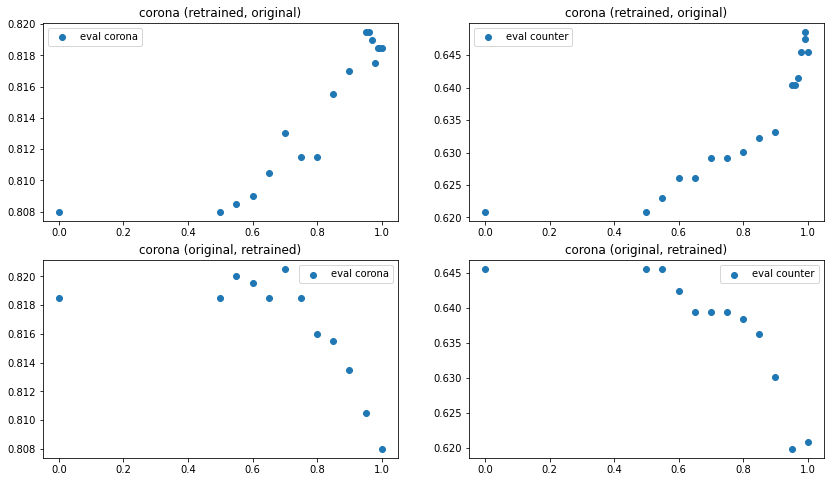

In [20]:
ensemble_results(folder_name, model_name, 'corona', 'counter', get_ds('corona')['test'], get_ds('counter')['test'], pad = True)

In [13]:
predict_sentences(model, tokenizer, device, [tokenizer.tokenize("i hate movies")])

tensor([[ 1.7911, -1.7094]], device='cuda:0', grad_fn=<AddmmBackward0>)


array([0])

In [14]:
predict_sentences(model, tokenizer, device, [tokenizer.tokenize("i love movies")])

tensor([[-2.3436,  2.2181]], device='cuda:0', grad_fn=<AddmmBackward0>)


array([1])